# Assignment 4: Discrimination
## CS 533: Intro to Data Science
Kevin Kirchoff<br>
Taso Kinnas

#### Requirements

Your task is to analyze the accuracy of the classifier with respect to actual post-release recidivism. How good is at predicting recidivism? How accurate is it at predicting violent recidivism?

In [1]:
# load necessary libraries
library(tidyverse)
library(modelr)
library(plotROC)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


In [2]:
#load data
data_raw = read_csv("data/compass/compas-scores-two-years.csv")
# spec(data_raw)
# str(data_raw)

Warning message:
"Duplicated column names deduplicated: 'decile_score' => 'decile_score_1' [40], 'priors_count' => 'priors_count_1' [49]"Parsed with column specification:
cols(
  .default = col_character(),
  id = col_integer(),
  compas_screening_date = col_date(format = ""),
  dob = col_date(format = ""),
  age = col_integer(),
  juv_fel_count = col_integer(),
  decile_score = col_integer(),
  juv_misd_count = col_integer(),
  juv_other_count = col_integer(),
  priors_count = col_integer(),
  days_b_screening_arrest = col_integer(),
  c_jail_in = col_datetime(format = ""),
  c_jail_out = col_datetime(format = ""),
  c_offense_date = col_date(format = ""),
  c_arrest_date = col_date(format = ""),
  c_days_from_compas = col_integer(),
  is_recid = col_integer(),
  r_days_from_arrest = col_integer(),
  r_offense_date = col_date(format = ""),
  r_jail_in = col_date(format = ""),
  r_jail_out = col_date(format = "")
  # ... with 13 more columns
)
See spec(...) for full column specificatio

In [3]:
# sets plot height to 3.5 inches
options(repr.plot.height=3.5)

In [4]:
# ProPublica filters 
df = dplyr::select(data_raw, age, c_charge_degree, race, age_cat, score_text, sex, priors_count,
                   days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, 
                   c_jail_out, everything()) %>%
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
# head(df)

In [5]:
# Data Transformation: make recitivism and violent recitivism boolean
relevant_data = df %>%
                mutate(recid = is_recid == 1) %>%
                mutate(v_recid = is_violent_recid == 1)

relevant_data$score_text = factor(relevant_data$score_text, levels = c("Low", "Medium", "High"), ordered=TRUE)

# head(relevant_data)
# str(relevant_data)

In [6]:
# Data selection: selecting relevant vectors
relevant_data = select(relevant_data, sex, race, decile_score, score_text, 
                  v_decile_score, v_score_text, 
                  recid, v_recid, is_recid, is_violent_recid)
head(relevant_data)

sex,race,decile_score,score_text,v_decile_score,v_score_text,recid,v_recid,is_recid,is_violent_recid
Male,Other,1,Low,1,Low,FALSE,FALSE,0,0
Male,African-American,3,Low,1,Low,TRUE,TRUE,1,1
Male,African-American,4,Low,3,Low,TRUE,FALSE,1,0
Male,Other,1,Low,1,Low,FALSE,FALSE,0,0
Male,Caucasian,6,Medium,2,Low,TRUE,FALSE,1,0
Male,Other,4,Low,3,Low,FALSE,FALSE,0,0


In [7]:
# build model to predict non-violent recitivism
model01 = glm(recid ~ decile_score,
            relevant_data, family=binomial())
summary(model01)


Call:
glm(formula = recid ~ decile_score, family = binomial(), data = relevant_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8562  -0.9900  -0.7831   1.0160   1.6319  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.30843    0.05237  -24.98   <2e-16 ***
decile_score  0.28344    0.01031   27.49   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 8550.2  on 6171  degrees of freedom
Residual deviance: 7681.0  on 6170  degrees of freedom
AIC: 7685

Number of Fisher Scoring iterations: 4


In [8]:
# build model to predict violent recitivism
model02 = glm(v_recid ~ v_decile_score,
            relevant_data, family=binomial())
summary(model02)


Call:
glm(formula = v_recid ~ v_decile_score, family = binomial(), 
    data = relevant_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8491  -0.5296  -0.3918  -0.3537   2.3677  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -2.95211    0.08256  -35.76   <2e-16 ***
v_decile_score  0.21176    0.01524   13.89   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4331.8  on 6171  degrees of freedom
Residual deviance: 4140.8  on 6170  degrees of freedom
AIC: 4144.8

Number of Fisher Scoring iterations: 5


In [9]:
# build predictions for model01 (non-violent offenses)
relevant_data = relevant_data %>%
    add_predictions(model01, var="model01_pred")

In [10]:
# build predictions for model02 (violent offenses)
relevant_data = relevant_data %>%
    add_predictions(model02, var="model02_pred")
head(relevant_data)

sex,race,decile_score,score_text,v_decile_score,v_score_text,recid,v_recid,is_recid,is_violent_recid,model01_pred,model02_pred
Male,Other,1,Low,1,Low,FALSE,FALSE,0,0,-1.0249894,-2.740354
Male,African-American,3,Low,1,Low,TRUE,TRUE,1,1,-0.4581068,-2.740354
Male,African-American,4,Low,3,Low,TRUE,FALSE,1,0,-0.1746655,-2.316839
Male,Other,1,Low,1,Low,FALSE,FALSE,0,0,-1.0249894,-2.740354
Male,Caucasian,6,Medium,2,Low,TRUE,FALSE,1,0,0.3922171,-2.528596
Male,Other,4,Low,3,Low,FALSE,FALSE,0,0,-0.1746655,-2.316839


## Start by doing some basic analysis of the accuracy:

### 1) Plot ROC curves for recidivism and violent recidivism, using the decile scores as the predictor.

PANEL,group,AUC
1,1,0.711162


PANEL,group,AUC
1,1,0.6569719


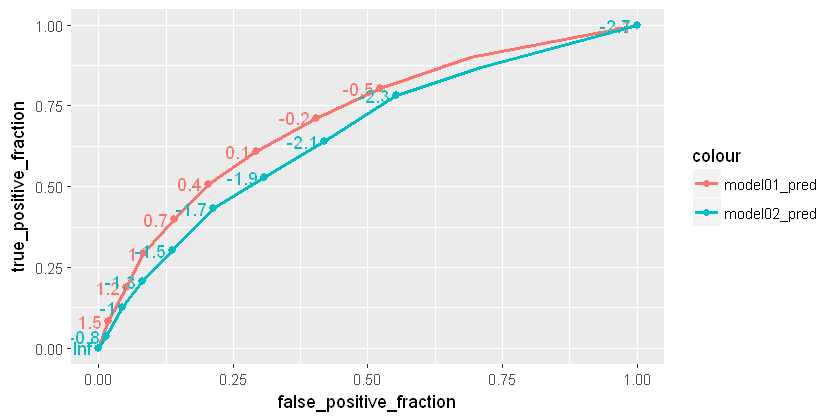

In [11]:
rocplot1 = ggplot(relevant_data, aes(d = is_recid, m = model01_pred, color="model01_pred")) + 
    geom_roc() +
    geom_roc(aes(d = is_violent_recid, m = model02_pred, color="model02_pred"))
rocplot2 = ggplot(relevant_data, aes(d = is_violent_recid, m = model02_pred, color="model02_pred")) +
    geom_roc()
rocplot1
calc_auc(rocplot1)
calc_auc(rocplot2)

### 2) Compute the precision (PPV), recall, false positive rate, and false negative rate for predicting both recidivism and violent recidivism, using 'High Risk' as the threshold for 'will recidivate'.

In [12]:
relevant_data = relevant_data %>%  
    mutate(will_recid = ifelse(score_text=="High",1,0)) %>%
    mutate(v_will_recid = ifelse(v_score_text=="High",1,0))    
relevant_data = relevant_data %>% 
    mutate(TP = (relevant_data$is_recid==1) & (relevant_data$will_recid==1)) %>%
    mutate(TN = (relevant_data$is_recid==0) & (relevant_data$will_recid==0)) %>%
    mutate(FP = (relevant_data$is_recid==0) & (relevant_data$will_recid==1)) %>%
    mutate(FN = (relevant_data$is_recid==1) & (relevant_data$will_recid==0)) %>%
    mutate(V_TP = (relevant_data$is_violent_recid==1) & (relevant_data$v_will_recid==1)) %>%
    mutate(V_TN = (relevant_data$is_violent_recid==0) & (relevant_data$v_will_recid==0)) %>%
    mutate(V_FP = (relevant_data$is_violent_recid==0) & (relevant_data$v_will_recid==1)) %>%
    mutate(V_FN = (relevant_data$is_violent_recid==1) & (relevant_data$v_will_recid==0))
# relevant_data 

precision = sum(relevant_data$TP)/(sum(relevant_data$TP)+sum(relevant_data$FP))
cat("precision", precision)
recall = sum(relevant_data$TP)/(sum(relevant_data$TP)+sum(relevant_data$FN))
cat("\nrecall: ", recall)
cat("\nFalse Positive: ",sum(relevant_data$FP)/(sum(relevant_data$FP)+sum(relevant_data$TN)))
cat("\nFalse Negative: ",sum(relevant_data$FN)/(sum(!relevant_data$FN)+sum(relevant_data$TP)))

v_precision = sum(relevant_data$V_TP)/(sum(relevant_data$V_TP)+sum(relevant_data$V_FP))
cat("\nprecision (violent): ", v_precision)
v_recall = sum(relevant_data$V_TP)/(sum(relevant_data$V_TP)+sum(relevant_data$V_FN))
cat("\nrecall (violent)", v_recall)

cat("\nFalse Positive (violent): ",sum(relevant_data$V_FP)/(sum(!relevant_data$V_FP)+sum(relevant_data$V_TN)))
cat("\nFalse Negative(violent): ",sum(relevant_data$V_FN)/(sum(!relevant_data$V_FN)+sum(relevant_data$V_TP)))

precision 0.7666084
recall:  0.293311
False Positive:  0.08390949
False Negative:  0.4280794
precision (violent):  0.2431507
recall (violent) 0.2052023
False Positive (violent):  0.04104755
False Negative(violent):  0.09541985

## Now we want to look at racial disparities; we will consider Caucasian, Black, and Hispanic.


### 1) Draw a bar chart that shows, for each race, and separately for violent and non-violent scoring, the likelihood that a defendant with each of the three risk score levels recidivates. The X axis should be risk score, and the Y axis should be likelihood of recidivism; facet_grid by race and whether we are looking at violent or general recidivism.

In [13]:
# filter on three races
race_data = filter(relevant_data, race == "Caucasian" | race == "African-American" | race == "Hispanic")
# head(race_data)

In [14]:
recid_prob = (select(race_data, race, score_text, recid)) %>%
    group_by(race, score_text) %>%
    summarize(count=n(), recid_mean = mean(recid))
v_recid_prob = (select(race_data, race, score_text, v_recid)) %>%
    group_by(race, score_text) %>%
    summarize(count=n(), v_recid_mean = mean(v_recid))
# head(recid_prob)
# head(v_recid_prob)

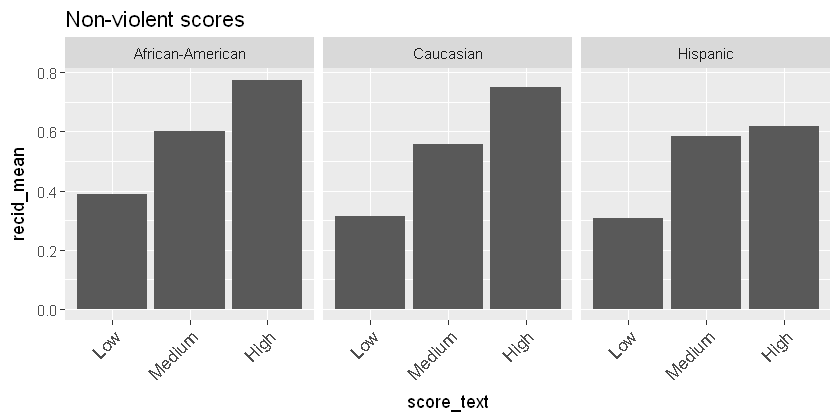

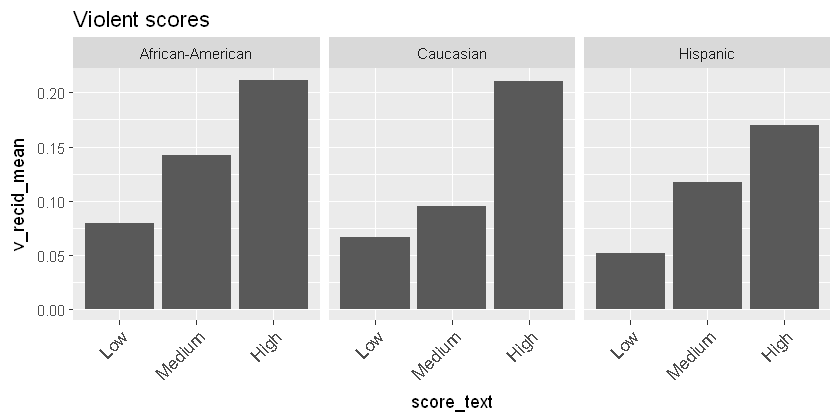

In [15]:
ggplot(recid_prob) +
    aes(x=score_text, y=recid_mean) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(.~race, scales="free") +
    theme(axis.text.x = element_text(size=10, angle=45, hjust=1)) +
    labs(title="Non-violent scores")
ggplot(v_recid_prob) +
    aes(x=score_text, y=v_recid_mean) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(.~race, scales="free") +
    theme(axis.text.x = element_text(size=10, angle=45, hjust=1)) +
    labs(title="Violent scores")

### 2) Compute the False Positive Rate for each race: what fraction of defendants who do not recidivate receive a high risk score?

In [16]:
# filter on three races
C = filter(race_data, race == "Caucasian")
#head(C)
C_FP = sum(C$FP)/(sum(C$FP)+sum(C$TN))
cat("False Positve Rate: Caucasian: ", C_FP)

A = filter(race_data, race == "African-American")
#head(A)
A_FP = sum(A$FP)/(sum(A$FP)+sum(A$TN))
cat("\nFalse Positve Rate: African-American: ", A_FP)

H = filter(race_data, race == "Hispanic")
#head(H)
H_FP = sum(H$FP)/(sum(H$FP)+sum(H$TN))
cat("\nFalse Positve Rate: Hispanic: ", H_FP)

False Positve Rate: Caucasian:  0.0455655
False Positve Rate: African-American:  0.1355207
False Positve Rate: Hispanic:  0.05769231

### 3) Compute the False Negative Rate for each race: what fraction of defendants who receive do recidivate receive a low risk score?

In [17]:
C_FN = sum(C$FN)/(sum(C$FN)+sum(C$TP))
cat("False Negative Rate: Caucasian: ", C_FN)

A_FN = sum(A$FN)/(sum(A$FN)+sum(A$TP))
cat("\nFalse Negative Rate: African-American: ",A_FN)

H_FN = sum(H$FN)/(sum(H$FN)+sum(H$TP))
cat("\nFalse Negative Rate: Hispanic: ", H_FN)

False Negative Rate: Caucasian:  0.8089245
False Negative Rate: African-American:  0.6305697
False Negative Rate: Hispanic:  0.8527919

### 4) Compute the Positive Predictive Value (or Precision) for each race.

In [18]:
precision_caucasian = sum(C$TP)/(sum(C$TP)+sum(C$FP))
cat("precision_caucasian: ",precision_caucasian)

precision_african = sum(A$TP)/(sum(A$TP)+sum(A$FP))
cat("\nprecision_african: ", precision_african)

precision_hispanic = sum(H$TP)/(sum(H$TP)+sum(H$FP))
cat("\nprecision_hispanic: ", precision_hispanic)

precision_caucasian:  0.7488789
precision_african:  0.7751479
precision_hispanic:  0.6170213

### 5) Compute the Negative Predictive Value for each race (what fraction of low-risk defendents do recidiviate).

In [19]:
neg_precision_caucasian = sum(C$TN)/(sum(C$TN)+sum(C$FN))
#summary(neg_precision_caucasian)
cat("neg_precision_caucasian: ", neg_precision_caucasian )

neg_precision_african = sum(A$TN)/(sum(A$TN)+sum(A$FN))
cat("\nneg_precision_african: ", neg_precision_african)

neg_precision_hispanic = sum(H$TN)/(sum(H$TN)+sum(H$FN))
cat("\nneg_precision_hispanic: ", neg_precision_hispanic)

neg_precision_caucasian:  0.6239362
neg_precision_african:  0.5201717
neg_precision_hispanic:  0.6363636

### 6) Plot ROC curves for each race (overlayed on top of each other — map the color and linetype aesthetics to race).

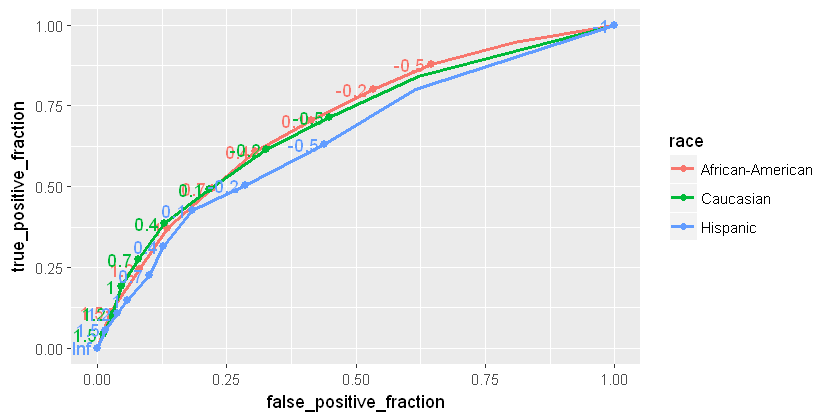

In [20]:
all_rocplot = ggplot(race_data, aes(d = is_recid, m = model01_pred, color=race)) + 
    geom_roc() # +

all_rocplot

## Finally, write:

### 1) Based on these analyses, write 1-2 paragraphs about how members of different races experience the prediction system.
<p>
In general, this system appears to be roughly 76% accurate with predicting recitivism.  Breaking that down by the three races, the data suggests the prediction system is about 10% less accurate for Hispanics, but fairly similar for Caucasians and African-Americans.  What's a little more telling is the error rates.  The false positives are over double for Afrivan-Americans compared to Caucasians and Hispanics have about a 50% higher false positive rate.  This suggests there is clearly a greater chance of error for non-Caucasians and it is not favorable to members of those race classes.  The disparity for false negative rates appear to be negligable between the races and doesn't appear to adversely impact  members based on race.
</p>

### 2) Write 1–2 paragraphs about why you think different metrics tell different stories. How can PPV be similar but FPR or FNR be different? Think about a confusion matrix to help you with this.
<p>
Different metrics tell different stories because they evalute different aspects of a given set of data.  PPV is evaluating accuracy, while FPR and FNR are evaluating the errors.  To drill down on that, FPR and FNR are evaluating different types of errors.  In this case, PPV predicts that someone "will commit another crime and actually does."  The FPR and FNR are looking at the errors in the prediction, respectivley "will commit another crime and doesn't" or "won't commit another crime and does."
</p>